## 4.1 nn.Module

实现 全连接层，又名 仿射层

In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable as V

In [2]:
class Linear(nn.Module):  # 继承 nn.Module
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()  # 等价于 nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
        
    def forward(self, x):
        x = x.mm(self.w)
        return x + self.b.expand_as(x)

In [3]:
layer = Linear(4, 3)  # 4*3
input_ = V(t.randn(2, 4))  # 2*4
output = layer(input_)
output  # 2*4  4*3 --> 2*3

tensor([[-1.8655e-03, -3.5455e+00, -9.6918e-02],
        [ 1.6632e+00, -5.4913e-01, -1.7291e+00]], grad_fn=<AddBackward0>)

In [4]:
for name, parameter in layer.named_parameters():
    print(name, parameter)  # w and b

w Parameter containing:
tensor([[-0.4568, -1.7042, -0.4438],
        [ 0.7593,  2.0908,  0.5670],
        [-0.1003, -0.1565,  1.4609],
        [ 1.2154,  0.9708, -0.5820]], requires_grad=True)
b Parameter containing:
tensor([ 1.4309, -0.8852, -0.7127], requires_grad=True)


注意：

`Parameter` 是一种特殊的 Variable ，但其默认要求求导

In [5]:
# 查看源码
# nn.Parameter??

多层感知机

In [6]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        nn.Module.__init__(self)
        self.layer1 = Linear(in_features, hidden_features)  # 前边定义的全连接层
        self.layer2 = Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = self.layer(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [7]:
perceptron = Perceptron(3, 4, 1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])


注意：

在传播函数中，我们有意识的将输出变量都命名成 x，是为了能让 Python 回收一些中间层的输出

PyTorch 实现了绝大多数神经网络的层， 使用`nn.layer?`查看

或 英文 ： https://pytorch.org/docs/nn.html

中文 https://pytorch-cn.readthedocs.io/zh/latest/

## 4.2 常用的神经网络层

### 4.2.1 图像相关层

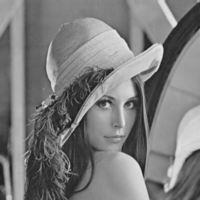

In [8]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()  # img -> tensor
to_pil = ToPILImage()
lena = Image.open('./imgs/lena.png')
lena

tensor([[-0.1111, -0.1111, -0.1111],
        [-0.1111,  1.0000, -0.1111],
        [-0.1111, -0.1111, -0.1111]])


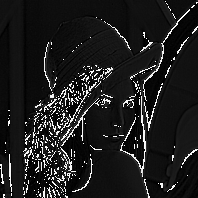

In [9]:
# 输入是一个 batch, batch_size = 1
input_ = to_tensor(lena).unsqueeze(0)

# 锐化卷积核
kernel = t.ones(3, 3) / -9
kernel[1][1] = 1
print(kernel)
# nn.Conv2d(
#     in_channels,
#     out_channels,
#     kernel_size,
#     stride=1,
#     padding=0,
#     dilation=1,
#     groups=1,
#     bias=True,
# )
conv = nn.Conv2d(1, 1, (3, 3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(V(input_))
to_pil(out.data.squeeze(0))

池化层可以看作是一种特殊的卷积层，用来下采样。但池化层没有可学习参数，其weight是固定的。

In [10]:
pool = nn.AvgPool2d(2, 2)
list(pool.parameters())

[]

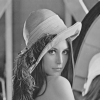

In [11]:
out = pool(input_)
to_pil(out.data.squeeze(0))


除了卷积层和池化层，深度学习中还将常用到以下几个层：

* Linear：全连接层。
* BatchNorm：批规范化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层。
* Dropout：dropout层，用来防止过拟合，同样分为1D、2D和3D。 下面通过例子来说明它们的使用

In [12]:
# 输入 batch_size=2，维度3
input_ = t.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input_)
h

tensor([[ 0.4430, -0.0201, -0.4277, -0.7815],
        [-0.6319,  0.5639, -0.3749, -0.4862]], grad_fn=<AddmmBackward>)

In [13]:
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
# 注意输出的均值和方差
# 方差是标准差的平方，计算无偏方差分母会减1
# 使用unbiased=False 分母不减1 (有偏估计)
bn_out.mean(0), bn_out.var(0, unbiased=False)

(tensor([0.0000e+00, 2.3842e-07, 0.0000e+00, 8.3447e-07],
        grad_fn=<MeanBackward0>),
 tensor([15.9994, 15.9981, 15.7737, 15.9927], grad_fn=<VarBackward1>))

In [14]:
# 每个元素以0.5的概率舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o  # 有一半左右的数变为0

tensor([[ 7.9999, -0.0000, -7.9432, -7.9982],
        [-7.9999,  0.0000,  7.9432,  0.0000]], grad_fn=<MulBackward0>)

### 4.2.2 激活函数

In [15]:
relu = nn.ReLU(inplace=True)
input_ = t.randn(2, 3)
print(input_)
output = relu(input_)
print(output)  # 小于 0 的都被截断为 0
# 等价于 input.clamp(min=0)

tensor([[-0.1148,  0.1368, -0.7513],
        [-1.4899, -0.6940, -0.4433]])
tensor([[0.0000, 0.1368, 0.0000],
        [0.0000, 0.0000, 0.0000]])


ReLU函数有个inplace参数，如果设为True，它会把输出直接覆盖到输入中，这样可以节省内存/显存。之所以可以覆盖是因为在计算ReLU的反向传播时，只需根据输出就能够推算出反向传播的梯度。但是只有少数的autograd操作支持inplace操作（如tensor.sigmoid_()），除非你明确地知道自己在做什么，否则一般不要使用inplace操作。

在以上的例子中，基本上都是将每一层的输出直接作为下一层的输入，这种网络称为前馈传播网络（feedforward neural network）。对于此类网络如果每次都写复杂的forward函数会有些麻烦，在此就有两种简化方式，ModuleList和Sequential。其中Sequential是一个特殊的module，它包含几个子Module，前向传播时会将输入一层接一层的传递下去。ModuleList也是一个特殊的module，可以包含几个子module，可以像用list一样使用它，但不能直接把输入传给ModuleList。

nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
    bias=True,
)

nn.BatchNorm2d(
    num_features,
    eps=1e-05,
    momentum=0.1,
    affine=True,
    track_running_stats=True,
)

In [16]:
# Sequential的三种写法
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.BatchNorm2d(3),
    nn.ReLU()
)

from collections import OrderedDict
net3 = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(3, 3, 3)),
    ('bn1', nn.BatchNorm2d(3)),
    ('relu1', nn.ReLU())
]))

print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [17]:
# 可根据名字或序号取出子module
net1.conv, net2[0], net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [18]:
input_ = t.rand(1, 3, 4, 4)
output = net1(input_)
output = net2(input_)
output = net3(input_)
output = net3.relu1(net1.batchnorm(net1.conv(input_)))
input_

tensor([[[[0.4100, 0.7178, 0.3294, 0.6208],
          [0.1371, 0.8605, 0.0604, 0.7945],
          [0.6242, 0.2733, 0.3477, 0.8116],
          [0.3448, 0.5087, 0.0608, 0.8335]],

         [[0.7105, 0.1777, 0.2963, 0.0403],
          [0.5532, 0.5284, 0.2733, 0.3879],
          [0.0578, 0.3468, 0.8144, 0.5535],
          [0.3428, 0.4008, 0.0786, 0.2371]],

         [[0.5421, 0.1725, 0.6102, 0.7023],
          [0.7635, 0.2380, 0.6650, 0.2077],
          [0.7651, 0.6839, 0.3251, 0.9007],
          [0.3803, 0.5430, 0.9938, 0.3910]]]])

In [19]:
modellist = nn.ModuleList([nn.Linear(3, 4), nn.ReLU(), nn.Linear(4, 2)])
input_ = t.randn(1, 3)
for model in modellist:
    input_ = model(input_)

In [20]:
# 下面会报错,因为modellist没有实现forward方法
# output = modellist(input_)
# NotImplementedError

ModuleList是Module的子类，当在Module中使用它的时候，就能自动识别为子module。

In [21]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [22]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


### 4.2.3 循环神经网络

入门资料（英文）

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### 4.2.4 损失函数

In [23]:
# batch_size=3，计算对应每个类别的分数（只有两个类别）
score = t.randn(3, 2)
# 三个样本分别属于1，0，1类，label必须是LongTensor
label = t.Tensor([1, 0, 1]).long()

# loss与普通的layer无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

tensor(0.7997)

## 4.3 优化器

PyTorch将深度学习中常用的优化方法全部封装在torch.optim中，其设计十分灵活，能够很方便的扩展成自定义的优化方法。

所有的优化方法都是继承基类optim.Optimizer，并实现了自己的优化步骤。

In [24]:
# 首先定义一个LeNet网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 全连接
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(), 
            nn.Linear(120, 84),
            nn.ReLU(), 
            nn.Linear(84, 10),
        )
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

net = Net()

In [25]:
from torch import optim
optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad()  # 梯度清零，等价于net.zero_grad()

input_ = t.randn(1, 3, 32, 32)
output = net(input_)
output.backward(output)  # fake backward

optimizer.step()  # 执行优化

In [26]:
# 为不同子网络设置不同的学习率，在finetune中经常用到
# 如果对某个参数不指定学习率，就使用最外层的默认学习率
optimizer = optim.SGD(
    [
        {'params': net.features.parameters()}, # 学习率为1e-5
        {'params': net.classifier.parameters(), 'lr': 1e-2}
    ],
    lr=1e-5
)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [27]:
# 只为两个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0], net.classifier[3]])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = filter(lambda p: id(p) not in special_layers_params,
                    net.parameters())

optimizer = t.optim.SGD(
    [
        {'params': base_params},
        {'params': special_layers.parameters(), 'lr': 0.01}
    ], 
    lr=0.001)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [28]:
# 方法1: 调整学习率，新建一个optimizer
old_lr = 0.1
optimizer1 = optim.SGD(
    [
        {'params': net.features.parameters()},
        {'params': net.classifier.parameters(), 'lr': old_lr*0.1}
    ],
    lr=1e-5
)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## 4.4 nn.functional

nn中还有一个很常用的模块：`nn.functional`，nn中的大多数layer，

在functional中都有一个与之相对应的函数。

`nn.functional`中的函数和`nn.Module`的主要区别在于，

用`nn.Module`实现的layers是一个特殊的类，都是由`class layer(nn.Module)`定义，

会自动提取可学习的参数。

而`nn.functional`中的函数更像是纯函数，由`def function(input)`定义。

In [29]:
input_ = t.randn(2, 3)
model = nn.Linear(3, 4)
output1 = model(input_)
output2 = nn.functional.linear(input_, model.weight, model.bias)
output1 == output2
# 返回一个矩阵，1 表示相同

tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]], dtype=torch.uint8)

In [30]:
b = nn.functional.relu(input_)
b2 = nn.ReLU()(input_)
b == b2

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.uint8)

如果模型有可学习的参数，最好用`nn.Module`，否则既可以使用`nn.functional`也可以使用`nn.Module`，二者在性能上没有太大差异

如激活函数（ReLU、sigmoid、tanh），池化（MaxPool）等层由于没有可学习参数，则可以使用对应的functional函数代替，而对于卷积、全连接等具有可学习参数的网络建议使用`nn.Module`。

虽然 dropout 操作也没有可学习操作，但建议还是使用`nn.Dropout`而不是`nn.functional.dropout`，因为 dropout 在训练和测试两个阶段的行为有所差别，使用`nn.Module`对象能够通过`model.eval`操作加以区分。

In [31]:
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(2)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

对于不具备可学习参数的层（激活层、池化层等），将它们用函数代替，这样则可以不用放置在构造函数`__init__`中

对于有可学习参数的模块，也可以用`functional`来代替，只不过实现起来较为**繁琐**，需要手动定义参数`parameter`，如前面实现自定义的全连接层，就可将`weight`和`bias`两个参数单独拿出来，在构造函数中初始化为`parameter`。

In [32]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))
    def forward(self):
        return F.linear(input, weight, bias)

## 4.5 初始化策略

PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略，因此一般不用我们考虑

当我们在使用`Parameter`时，**自定义初始化**则尤为重要，因`t.Tensor()`返回的是**内存中的随机数**，很可能会有极大值，这在实际训练网络中会造成**溢出**或者**梯度**消失。

PyTorch中`nn.init`模块就是专门为初始化而设计

In [33]:
# 利用nn.init初始化
from torch.nn import init
linear = nn.Linear(3, 4)

t.manual_seed(1)
# 等价于 linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]], requires_grad=True)

In [34]:
# 直接初始化
import math
t.manual_seed(1)

# xavier初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.)
linear.weight.data.normal_(0, std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [35]:
# 对模型的所有参数进行初始化
for name, params in net.named_parameters():
    if name.find('linear') != -1:
        # init linear
        params[0] # weight
        params[1] # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass

## 4.5 nn.Module深入分析

`nn.Module`基类的构造函数
```python
def __init__(self):
    self._parameters = OrderedDict()
    self._modules = OrderedDict()
    self._buffers = OrderedDict()
    self._backward_hooks = OrderedDict()
    self._forward_hooks = OrderedDict()
    self.training = True
```

* `_parameters`：字典，保存用户直接设置的parameter，`self.param1 = nn.Parameter(t.randn(3, 3))`会被检测到，在字典中加入一个key为'param'，value为对应parameter的item。而self.submodule = nn.Linear(3, 4)中的parameter则不会存于此。
* `_modules`：子module，通过`self.submodel = nn.Linear(3, 4)`指定的子module会保存于此。
* `_buffers`：缓存。如batchnorm使用momentum机制，每次前向传播需用到上一次前向传播的结果。
* `_backward_hooks`与`_forward_hooks`：钩子技术，用来提取中间变量，类似variable的hook。
* `training`：`BatchNorm`与`Dropout`层在训练阶段和测试阶段中采取的策略不同，通过判断training值来决定前向传播策略。

`_parameters`、`_modules`和`_buffers`这三个字典中的键值，都可以通过`self.key`方式获得，效果等价于`self._parameters['key']`.



In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 等价与self.register_parameter('param1' ,nn.Parameter(t.randn(3, 3)))
        self.param1 = nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4)
    
    def forward(self, input_):
        x = self.param1.mm(input_)
        x = self.submodel1(x)
        return x

net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [37]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [38]:
net.submodel1

Linear(in_features=3, out_features=4, bias=True)

In [39]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[0.3398, 0.5239, 0.7981],
                      [0.7718, 0.0112, 0.8100],
                      [0.6397, 0.9743, 0.8300]], requires_grad=True))])

In [40]:
net.param1 # 等价于net._parameters['param1']

Parameter containing:
tensor([[0.3398, 0.5239, 0.7981],
        [0.7718, 0.0112, 0.8100],
        [0.6397, 0.9743, 0.8300]], requires_grad=True)

In [41]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [42]:
for name, submodel in net.named_modules():
    print(name, submodel)

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [43]:
bn = nn.BatchNorm1d(2)
input_ = t.rand(3, 2)
output = bn(input_)
bn._buffers

OrderedDict([('running_mean', tensor([0.0514, 0.0749])),
             ('running_var', tensor([0.9116, 0.9068])),
             ('num_batches_tracked', tensor(1))])

`nn.Module`在实际使用中可能层层嵌套，一个module包含若干个子module，每一个子module又包含了更多的子module。

为方便用户访问各个子module，`nn.Module`实现了很多方法，如函数`children`可以查看**直接**子module，`函数module`可以查看**所有**的子module（包括当前module）。

与之相对应的还有函数`named_childen`和`named_modules`，其能够在返回module列表的同时返回它们的名字。

In [44]:
input_ = V(t.arange(0, 12).view(3, 4))
# model = nn.Dropout()
# 在训练阶段，会有一半左右的数被随机置为0
# model(input_)
# 运行这句 kernal 会挂掉

对于batchnorm、dropout、instancenorm等在训练和测试阶段行为差距巨大的层，如果在测试时不将其`training值`设为`True`，则可能会有很大影响

虽然可通过直接设置`training属性`，来将子module设为`train`和`eval`模式，但这种方式较为繁琐，因如果一个模型具有多个dropout层，就需要为每个dropout层指定training属性。更为**推荐**的做法是调用`model.train()函数`，它会将当前module及其子module中的所有training属性都设为True，相应的，model.eval()函数会把training属性都设为False。

In [45]:
print(net.training, net.submodel1.training)
net.eval()
net.training, net.submodel1.training

True True


(False, False)

In [46]:
list(net.named_modules())

[('', Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )), ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

有一个预训练好的模型，需要提取模型的某一层（不是最后一层）的输出作为特征进行分类，但又不希望修改其原有的模型定义文件，这时就可以利用钩子函数。

```python
model = VGG()
features = t.Tensor()
def hook(module, input, output):
    '''把这层的输出拷贝到features中'''
    features.copy_(output.data)

handle = model.layer8.register_forward_hook(hook)
_ = model(input)
# 用完hook后删除
handle.remove()
```

`nn.Module`对象在构造函数中的行为看起来有些怪异，如果想要真正掌握其原理，就需要看两个魔法方法`__getattr__`和`__setattr__`。

在Python中有两个常用的buildin方法`getattr`和`setattr`，

`getattr(obj, 'attr1')`等价于`obj.attr`，如果`getattr`函数无法找到所需属性，Python会转而调用`obj.__getattr__('attr1')`方法，即`getattr`函数无法找到的交给`__getattr__`函数处理，没有实现`__getattr__`或者`__getattr__`也无法处理的就会`raise AttributeError`。

`setattr(obj, 'name', value)`等价于`obj.name=value`，如果obj对象实现了`__setattr__`方法，`setattr`会直接调用`obj.__setattr__('name', value)`，否则调用buildin方法。

总结一下：

* `result = obj.name`会调用buildin函数`getattr(obj, 'name')`，如果该属性找不到，会调用`obj.__getattr__('name')`

* `obj.name = value`会调用buildin函数`setattr(obj, 'name', value)`，如果obj对象实现了`__setattr__`方法，setattr会直接调用`obj.__setattr__('name', value')`


`nn.Module`实现了自定义的`__setattr__`函数，当执行`module.name=value`时，会在`__setattr__`中判断value是否为`Parameter`或`nn.Module`对象，如果是则将这些对象加到`_parameters`和`_modules`两个字典中，而如果是其它类型的对象，如`Variable`、`list`、`dict`等，则调用默认的操作，将这个值保存在`__dict__`中。

In [47]:
module = nn.Module()
module.param = nn.Parameter(t.ones(2, 2))
module._parameters

OrderedDict([('param', Parameter containing:
              tensor([[1., 1.],
                      [1., 1.]], requires_grad=True))])

In [48]:
submodule1 = nn.Linear(2, 2)
submodule2 = nn.Linear(2, 2)
module_list= [submodule1, submodule2]
# 对于list对象，调用buildin函数，保存在__dict__中
module.submodules = module_list
print('_modules: ', module._modules)
print("__dict__['submodules']:", module.__dict__.get('submodules'))

_modules:  OrderedDict()
__dict__['submodules']: [Linear(in_features=2, out_features=2, bias=True), Linear(in_features=2, out_features=2, bias=True)]


In [49]:
module_list = nn.ModuleList(module_list)
module.submodules = module_list
print('ModuleList is instance of nn.Module: ', isinstance(module_list, nn.Module))
print('modules: ', module._modules)
print("__dict__['submodules']:", module.__dict__.get('submodules'))

ModuleList is instance of nn.Module:  True
modules:  OrderedDict([('submodules', ModuleList(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
))])
__dict__['submodules']: None


因_`modules`和_`parameters`中的item未保存在`__dict__`中，所以默认的`getattr`方法无法获取它，因而`nn.Module`实现了自定义的`__getattr__`方法，如果默认的`getattr`无法处理，就调用自定义的`__getattr__`方法，尝试从`_modules`、`_parameters`和`_buffers`这三个字典中获取。

In [53]:
getattr(module, 'training')  # 等价于 module.training
# error  AttributeError
# module.__getattr__('training')

True

In [58]:
module.attr1 = 2
getattr(module, 'attr1')
# 报错
# module.__getattr__('attr1')

2

In [59]:
# 即 module.param, 会调用 module.__getattr__('param')
getattr(module, 'param')

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

在PyTorch中**保存模型**十分简单，所有的`Module`对象都具有`state_dict()`函数，返回当前Module所有的状态数据。将这些状态数据保存后，下次使用模型时即可利用`model.load_state_dict()`函数将状态**加载**进来。**优化器（optimizer）**也有类似的机制，不过一般并不需要保存优化器的运行状态。



In [60]:
# 保存模型, 第二个参数为 path
t.save(net.state_dict(), 'net.pth')

# 加载已保存的模型
net2 = Net()
net2.load_state_dict(t.load('net.pth'))

另外一种保存方法，但因其严重依赖**模型定义方式**及**文件路径结构**等，很容易出问题，因而**不建议使用**。

In [62]:
t.save(net, 'net_all.pth')
net2 = t.load('net_all.pth')
net2

/home/gaoshuai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

将Module放在**GPU**上运行也十分简单，只需两步：

* `model = model.cuda()`：将模型的所有参数转存到GPU
* `input.cuda()`：将输入数据也放置到GPU上

至于如何在多个GPU上**并行计算**，PyTorch也提供了两个函数，可实现简单高效的并行GPU计算

* `nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)`
* `class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)`

可见二者的参数十分相似，通过`device_ids`参数可以**指定在哪些GPU上进行优化**，`output_device`指定**输出到哪个GPU**上。唯一的**不同**就在于前者直接利用多GPU并行计算得出结果，而后者则返回一个新的module，能够自动在多GPU上进行并行加速。

```python
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

`DataParallel`并行的方式，是将输入一个batch的数据均分成多份，分别送到对应的GPU进行计算，各个GPU得到的梯度累加。与Module相关的所有数据也都会以浅复制的方式复制多份，在此需要注意，在module中属性应该是只读的。

## 4.7 nn和autograd的关系

## 4.8 小试牛刀：搭建ResNet

* 对于模型中的重复部分，实现为子module或用函数生成相应的modulemake_layer
* nn.Module和nn.Functional结合使用
* 尽量使用nn.Seqential
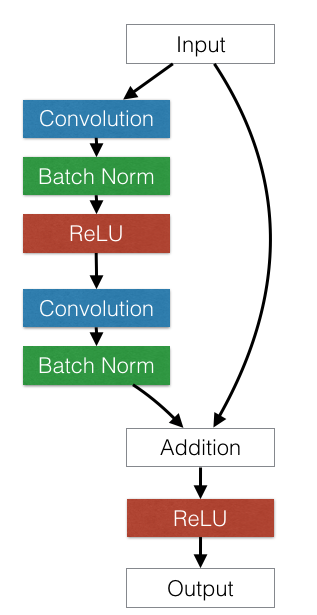

In [63]:
from torch import nn
import torch as t
from torch.nn import functional as F

In [72]:
class ResidualBlock(nn.Module):
    """
    实现子module: Residual Block             
    """
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.right = shortcut
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)


class ResNet(nn.Module):
    """
    实现主module：ResNet34
    ResNet34 包含多个layer，每个layer又包含多个residual block
    用子module来实现residual block，用_make_layer函数来实现layer
    """
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        
        # 重复的layer，分别有3，4，6，3个residual block
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        
        #分类用的全连接
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        """
        构建layer,包含多个residual block
        """
        shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 1, stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        
        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))
        
        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))
        # * 任意多个参数并将其放在一个元组
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [73]:
model = ResNet()
input_ = t.randn(1, 3, 224, 224)
o = model(input_)

In [78]:
models.resnet34??

In [77]:
# 通过下面两行代码使用
from torchvision import models
model = models.resnet34()